# Dive into Deep Learning

By Jasmine Young


### The Task

In this blog post we will be using data from [Insect Images](https://www.insectimages.org/index.cfm) to train a deep learning model to classify beetles, cockroaches, and dragonflies. We'll explain the model, measure performance, and explain how the neural network is classifying images with [Shapley Additive Explanations](https://github.com/slundberg/shap). 

In [1]:
#collapse
from __future__ import print_function
import numpy as np 
import pandas as pd
import os, sys
from numpy import asarray
from PIL import Image
from sklearn.neural_network import MLPClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow
from tensorflow.keras import backend as K
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### Data Pre-Processing

We begin by loading the images of cockroaches, beetles, and dragonflies in our train folder and test folder. We then combine all of our training images into one place with their proper labels, and all of our testing images into one place with their proper labels. Lastly we transform our images into numpy arrays so that they can be fed into the model.

Here's an example dragonfly image:

In [2]:
#collapse
'''
Load training data
'''

folder = "insects/train/beetles"

beetles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


folder = "insects/train/cockroach"

cockroaches = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


folder = "insects/train/dragonflies"

dragonflies = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


In [3]:
#collapse
'''
Load testing data
'''

folder = "insects/test/beetles"

test_beetles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


folder = "insects/test/cockroach"

test_cockroaches = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


folder = "insects/test/dragonflies"

test_dragonflies = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]


In [4]:
#collapse
'''
Create full collection of training images and labels
'''
train_files = []
y_train = []
i=0
for _file in beetles:
    train_files.append('insects/train/beetles/' + _file)
    y_train.append(0)
    
for _file in cockroaches:
    train_files.append('insects/train/cockroach/' + _file)
    y_train.append(1)
    
for _file in dragonflies:
    train_files.append('insects/train/dragonflies/' + _file)
    y_train.append(2)

In [5]:
#collapse
'''
Create full collection of test images and labels
'''
test_files = []
y_test = []
i=0
for _file in test_beetles:
    test_files.append('insects/test/beetles/' + _file)
    y_test.append(0)
    
for _file in test_cockroaches:
    test_files.append('insects/test/cockroach/' + _file)
    y_test.append(1)
    
for _file in test_dragonflies:
    test_files.append('insects/test/dragonflies/' + _file)
    y_test.append(2)

In [6]:
#collapse
'''
Turn Training Images to Numpy Arrays 
'''
# Set Image Dimensions
image_width = 480
image_height = 480
ratio = 4

image_width = int(image_width / ratio)
image_height = int(image_height / ratio)

channels = 3
nb_classes = 1

#Create training dataset of images as numpy arrays
dataset = np.ndarray(shape=(len(train_files),image_height,image_width,channels),
                     dtype=np.float32)
x_train = []
i = 0
for _file in train_files:
    img = load_img(_file)  
    img = img.resize((image_width, image_height))
    # Convert to Numpy Array
    x = asarray(img)
    dataset[i] = x
    i += 1

In [7]:
#collapse
'''
Turn Testing Images to Numpy Arrays
'''
test_dataset = np.ndarray(shape=(len(test_files), image_height,image_width,channels),
                     dtype=np.float32)
x_test = []
i = 0
for _file in test_files:
    img = load_img(_file) 
    img = img.resize((image_width, image_height))
    # Convert to Numpy Array
    x = asarray(img)
    test_dataset[i] = x
    i += 1

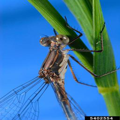

In [8]:
img

### Creating The Model

We're using a Sequential model from the Keras library with the following layers:
- A 2D convolution layer with a relu activation function
- A MaxPooling layer for 2-Dimensional data that downsamples the input by taking the max value among the pool size window (2,2).
- A Dropout layer that randomly sets inputs to zero at the rate 0.25 to prevent overfitting.
- A Flatten layer that flattens the input.
- A Dense layer that implements the 'relu' activation function.
- Another Dropout layer that reandomly sets inputs to zero at the rate 0.5 to prevent overfitting.
- A final Dense layer to implement the 'softmax' activation function.

In [9]:
#collapse
'''
Tidy up input dataset
'''
dataset = dataset.astype('float32')
test_dataset = test_dataset.astype('float32')
dataset /= 255
test_dataset /= 255

'''
Set model values
'''
batch_size = 128
epochs = 25
num_classes = 3
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
input_shape = (image_height,image_width,channels)

'''
Build Model
'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
             metrics=['accuracy'])


In [10]:
'''
Fit Model to Our Data
'''
hist = model.fit(dataset, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/25
8/8 [==============================] - 4s 521ms/step - loss: 18.0087 - accuracy: 0.4308
Epoch 2/25
8/8 [==============================] - 4s 516ms/step - loss: 1.3599 - accuracy: 0.6212
Epoch 3/25
8/8 [==============================] - 4s 545ms/step - loss: 0.7698 - accuracy: 0.6673
Epoch 4/25
8/8 [==============================] - 5s 636ms/step - loss: 0.7131 - accuracy: 0.7134
Epoch 5/25
8/8 [==============================] - 4s 546ms/step - loss: 0.5829 - accuracy: 0.7566
Epoch 6/25
8/8 [==============================] - 4s 538ms/step - loss: 0.5741 - accuracy: 0.7704
Epoch 7/25
8/8 [==============================] - 4s 515ms/step - loss: 0.4956 - accuracy: 0.7949
Epoch 8/25
8/8 [==============================] - 4s 525ms/step - loss: 0.7153 - accuracy: 0.7674
Epoch 9/25
8/8 [==============================] - 4s 507ms/step - loss: 0.3780 - accuracy: 0.8597
Epoch 10/25
8/8 [==============================] - 5s 568ms/step - loss: 0.3362 - accuracy: 0.8763
Epoch 11/25
8/8 [=

### Evaluating Our Model

We see that our model performs fairly well, with a test loss of 0.095 and a test accuracy of 0.978. The plots below show the change in loss across epochs, and the improvements in accuracy at each epoch. I found that there were minimal accuracy gains from adding more than 25 epochs.

In [11]:
'''
Evaluate Our Model
'''
score = model.evaluate(test_dataset, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.42263150215148926
Test accuracy: 0.8111110925674438


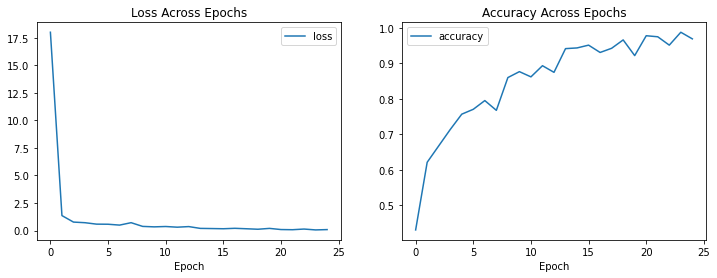

In [12]:
#collapse
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure, title in zip(axes, ['loss', 'accuracy'], ['Loss Across Epochs','Accuracy Across Epochs']):
    ax.plot(hist.history[measure], label=measure)
    ax.title.set_text(title)
    ax.set_xlabel('Epoch')
    ax.legend()
pass

### Understanding Our Model With Shapley

Below we use [Shapley Additive Explanations](https://github.com/slundberg/shap) to understand how our deep learning model is classifying images. The first two images are beetles, the next two images are cockroaches, and the last two images are dragonflies. We use shapley's deep explainer which works by approximating a certain number of samples from our model - in this case 200 images. Red pixels are increasing the model's output while blue pixels are decreasing the model's output. The sum of SHAP values represents the difference between the expected model output and the current model output.

We see our beetle images highlighted with red pixels in the first (beetle) column. Our cockroach images are highlighted with red pixels in the center (cockroach) column - though one of our cockroaches has some red pixels in the dragonfly column. Lastly, our two dragonfly images are highlighted with red pixels in the final (dragonfly) column - though has some red pixels in the cockroach column. 

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


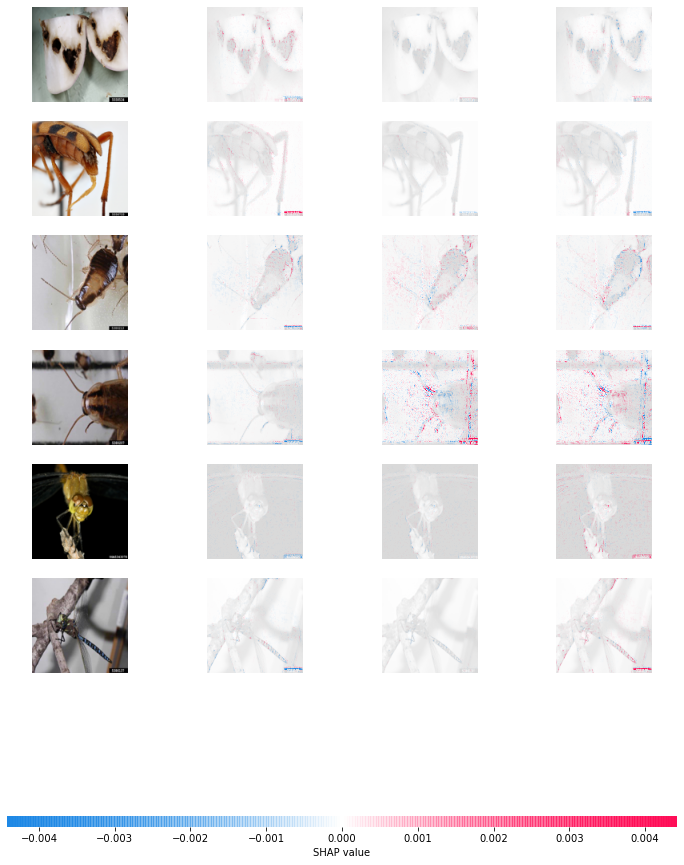

In [13]:
#collapse
import shap
import numpy as np

'''
Select a set of background examples to take an expectation over
'''
background = dataset[np.random.choice(dataset.shape[0], 200, replace=False)]

e = shap.DeepExplainer(model, background)

'''
Run the explainer for certain images in our dataset
'''
shap_values = e.shap_values(test_dataset[[1,2,65,66,154,158]])

shap.image_plot(shap_values, test_dataset[[1,2,65,66,154,158]])